# Assorted Notes

## Chapter 8: Planning and Learning with Tabular Methods

Model based methods use planning as their primary component, while model free methods rely on learning. At the heart of both kinds of methods is value function approximation. All of the methods are based on looking ahead to future events, computing a backed-up value, and then using it as an update target for an approximate value function.

### 8.1: Models and Planning

A model of the environment is meant as anything the agent can use to predict how the environment will respond to its actions. When a model is given a state and an action, it predicts the resultant next state and the reward. Some models, called distribution models, produce a description of all possibilities and their probabilities. Other models, called sample models, produce just one of the possibilities, sampled based on the probabilities. The model type assured in dynamic programming, $p(s', r | s, a)$ is a distribution model. The kind of model used in blackjack is a sample model. 

A distribution model is stronger than a sample model because it can always be used to produce samples. But, a sample model is frequently much easier to get than a distribution model. 

We can use models to simulate experience. In this context, the word planning is used to refer to the process of taking a model as input and producing or improving a policy for interacting with the modeled environment. 

In [1]:
from IPython.display import Image

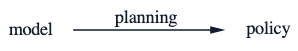

In [5]:
Image(filename='planning.png')

*State-space planning* is the approach taken in the book and is looked at as the search through state space for an optimal policy or an optimal path to a goal. 

All state-space planning methods share some pieces of a common structure:
- 'all state-space planning methods involve computing value functions as a key intermediate step toward improving the policy'
- 'the compute value functions by updates or backup functions applied to simulated experience'

Diagram of this:

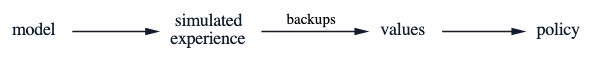

In [8]:
Image(filename='planning_structure.png')

Looking at planning methods in this manner emphasizes their relationship to the learning methods in the book. 

## Part 2: Approximate Solution Methods

Often we'd like to apply RL where the state-space is too big for tabular methods. In this case, we can't expect to find an optimal policy or optimal value function, even with infinite time or data, instead we need to produce a good-enough approximation. Often, with a large state space, the issue is that often we will find ourselves in a situation we have never seen before. It is essential then that our methods be able to generalize from past experience to make good decisions in these new situations. 

We need function approximators for this task. Theoretically any function approximator will work with RL, but some work easier than others. 

RL + function approximation involves many new issues that don't normally show up in supervised learning, like nonstationarity, bootstrapping, and delayed targets. 

## Chapter 9: On-Policy Prediction with Approximation

Here we look at using function approximation to estimate $v_\pi$ from on-policy data. aka we estimate $v_\pi$ using experience generated following $\pi$ where $\pi$ is known. 

We start representing the approximate value function as a parameterized function with a weight vector $\textbf{w} \in R^d$. Write $\hat{v}(s, \textbf{w}) \approx v_\pi(s)$ as the approximate value of state $s$ when given the vector $\textbf{w}$. $\hat{v}$ might be the function approximated by an NN with $\textbf{w}$ being the weight connections in each layer. Regularly, the num of weights is less than the number of states so changing one weight changes the approximated values of many states. As a result, when one state is updated, the change generalizes from that state to affect the values of lots of other states. Generalization makes what is learned more powerful but also makes it harder to understand and to manage.

Extending RL to function approximation also makes it work on partially observable problems. If $\hat{v}$ doesn't depend on all aspects of the state, then its just like if those parts of the state are not observable. 

However, function approximation cannot augment the state representation with memories of past observations.

## 9.1: Value-function Approximation

The prediction methods so far covered have been described as updates to an estimated value function. The update rule shifts its value at states towards an update target for the state. Refer to an individual update by the notation $s \mapsto u$. $s$ is the state updated and $u$ is the target. 

Now we use function approximation to do the update. Before it was simple update rules. Function approximation expects example input-output behaviors of the function trying to approximate. We'll use these kinds of methods for value prediction by giving them the $s \mapsto u$ for each update as a training example. Then we can interpret the approximate function produced as the estimated value function. 

Looking at it this way lets us use a wide range of existing function approximation methods for value prediction. Theoretically, we can use any method for supervised learning from examples. But not all of the methods are equally good for RL. Neural networks and statistical methods assume a static training set to make repeated passes over. RL needs that learning can occur online, with a dynamic training set, as the agent interacts with the environment. This requires a method that can learn efficiently from incrementally acquired data. Additionally, RL needs function approximation methods that can handle nonstationary target functions. i.e. in control methods with GPI, we are trying to learn $q_\pi$ while the policy is changing. Even if the policy doesn't change, targe values of training examples are nonstationary if they are generated by bootstrapping methods like DP or TD. 

### 9.2: The Prediction Objective $(\overline{VE})$

We haven't yet specified an objective for prediction. When we were in the tabular case we didn't need a continuous measure of prediction quality because we could guarantee that the learned value function would eventually converge to the true value function. Additionally, the learned values at one state did not affect the values learned of other states. With true approximation, however, an update at one state affects other states. So it is not possible to get all of the state values exactly right. We assume to have many more states than we do weights, so making one state have a more accurate estimate always means making another state's estimate less accurate. This means that we have to say which states we care most about. 

Must specify a state distribution $\mu (s) \geq 0, \space \sum_s \mu(s) = 1$, this represents how much we care about the error in each state $s$. The error measure we mean is the square of the difference between the approximate value $\hat{v}(s, \textbf{w})$ and true value $v_\pi(s)$. When we weight this over the state space by $\mu$, we get *Mean Squared Value Error*, denoted by $\overline{VE}$. 

$\overline{VE} \stackrel{.}{=} \sum_{s \in S} \mu(s) [v_\pi(s) - \hat{v}(s, \textbf{w})]^2 \quad \quad (9.1)$

The square root of this, the root $\overline{VE}$, gives us a rough measure of how much the approximate values differ from true values and it is often used in plots. Under on-policy training this is called the on-policy distribution, in continuing tasks this is the stationary distribution under $\pi$. 

On policy distribution in episodic tasks:

On policy distribution is a little different here because it depends on how the initial states of episodes are chosen. Make $h(s)$ denote probability that an episode begins in each state and let $\eta(s)$ be the number of time steps spent on average in state $s$ in an episode. Time is spent in $s$ if episodes start in $s$ or if transitions are made into $s$ from a preceding state $\overline{s}$. 

$\eta(s) = h(s) + \sum_{\overline{s}} \eta(\overline{s}) \sum_a \pi(a|\overline{s}) p(s | \overline{s}, a), \forall \quad s \in S \quad \quad (9.2)$

The system of eqns can be solved for the expected number of visits $\eta(s)$. On policy dist is the fraction of time spent in each state normalized to sum up to one:

$\mu(s) = \frac{\eta(s)}{\sum_{s'} \eta(s')}, \space \forall \quad s \in S \quad \quad (9.3)$

We choose this without discounting. If there is discounting we can include it by adding a factor of $\gamma$ in the second term of (9.2)